### Florian Muthreich   ---   INF368   ---

# Assignment 1

Load necessary packages

In [1]:
import matplotlib.pyplot as plt
import keras
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers

Using TensorFlow backend.


---
Next I download the MNIST dataset. It is already split in test and training set and saved to variables. The images are stored separately from the labels in arrays.

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

---
The MNIST set has been downloaded and I can show the dimensions of the dataset.
In total there are 70000 images of handwritten numbers. 60000 in the train set and 10000 in the test set. each image is 28 x 28 pixels and has only one channel, which means each cell indicates the intensity of a pixel. The labels are stored separately in their own array, which basically has the shape of a vector.

In [3]:
print("Training set:",x_train.shape, ", labels", y_train.shape)
print("Test set:",x_test.shape, ", labels", y_test.shape)

Training set: (60000, 28, 28) , labels (60000,)
Test set: (10000, 28, 28) , labels (10000,)


---
Here I plot 6 random images from the MNIST dataset. 3 from the train and 3 from the test set.

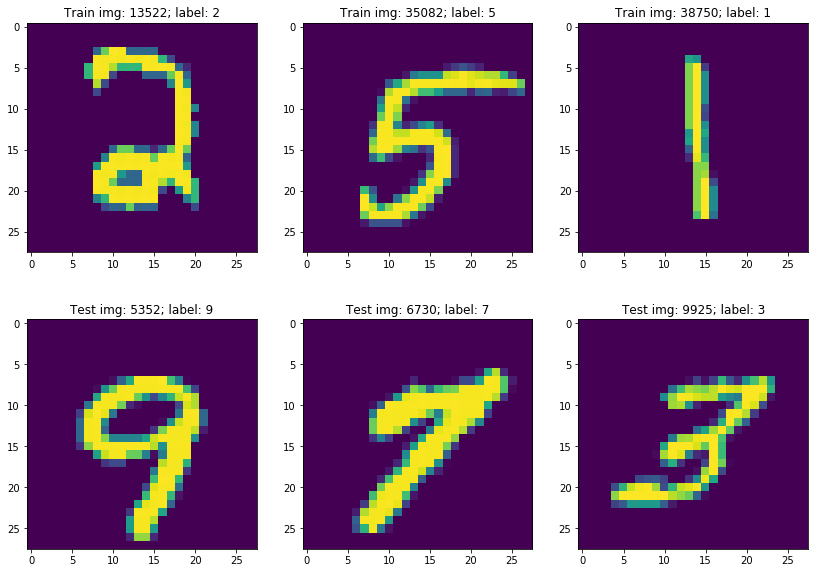

In [5]:
plt.rcParams["figure.figsize"] = (14,10)
for x in range(6):
    if x<3:
        i = random.randint(1,x_train.shape[0])
        plt.subplot(2, 3, x+1)
        plt.imshow(x_train[i])
        plt.title("Train img: {}; label: {}".format(i,y_train[i]))
    else:
        i = random.randint(1,x_test.shape[0])
        plt.subplot(2, 3, x+1)
        plt.imshow(x_test[i])
        plt.title("Test img: {}; label: {}".format(i,y_test[i]))
        
plt.show()

---
I defined a function to transform the training data into 4D vectors. The same function also converts the labels into one hot coded vectors. 

In [3]:
def res_rec(data, labels, channels):
    tmp = data.reshape(data.shape[0], channels, data.shape[1], data.shape[2])
    tmp = tmp.astype("float32")
    tmp = tmp/np.amax(x_train)
    lbl = keras.utils.to_categorical(labels, len(np.unique(labels)))
    return tmp, lbl

x_train, y_train = res_rec(x_train, y_train, 1)
x_test, y_test = res_rec(x_test, y_test, 1)

print("Training set:",x_train.shape, ", labels", y_train.shape)
print("Test set:",x_test.shape, ", labels", y_test.shape)

Training set: (60000, 1, 28, 28) , labels (60000, 10)
Test set: (10000, 1, 28, 28) , labels (10000, 10)


---
This model has 1 hidden layer with 50 units and a second layer with 10 softmax units. I added another layer before the first hidden layer to convert the picture data from a 28 x 28 matrix into a vector, this is done by the flatten layer. there are no weights learned in this layer, hust a transformation from 2 dimensions to 1. The number of parameters can be easily derived from this model description.

We have 784 input features that are connected to 50 hidden units in the first layer (1). Each unit also has a weight for the bias (2). In the next layer, the 50 units of the first hidden unit are connected to the 10 Softmax units with weights for each connection in addition to weights for the bias of each node in the Softmax layer (3). This brings the total to 39760 parameters. We can see the number of trainable parameters with the model.summary() command.

1) 784 * 50 = 39200

2) 39200 + 50 = 39250

3) 50 * 10 + 10 = 510


In [33]:
def simple_NN(x_train, y_train, x_valid, y_valid, L2 = 0.001, activation = "relu", LR = 0.01):
    from keras import optimizers
    model = Sequential([
        Flatten(input_shape = (1,28, 28), name = "flatten"),
        Dense(50, name = "hidden_1", kernel_regularizer=regularizers.l2(L2),),
        Activation(activation, name = "act_hidden_1"),
        Dense(10, name = "out"),
        Activation("softmax", name = "act_out")
    ])
    sgd = optimizers.SGD(lr=LR, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer = sgd,
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])
    checkpoints = keras.callbacks.ModelCheckpoint("./checkpoints/model_{epoch:02d}.hdf5", 
                                              monitor='val_loss', 
                                              verbose=0, 
                                              save_best_only=False, save_weights_only=False)
    history = model.fit(x_train, y_train, 
                    epochs = 10, batch_size = 64, 
                    callbacks = [checkpoints], 
                    validation_data = (x_valid, y_valid))
    return model, history

---
The training data is split into training and validation (development) set. I randomly select 5000 (1/12) images of the training set and their corresponding labels and save them as the validation set, to check performance during training. 

In the last line of the code I call a function that will save model checkpoints and the weights after each epoch. This way I can go back to each point during training and recreate the model and its weight from that point in the training process. 

In [5]:
ind = random.sample(range(x_train.shape[0]), int(1/12 * x_train.shape[0]))
x_valid, y_valid = x_train[ind], y_train[ind]
x_train, y_train = np.delete(x_train, ind, axis = 0), np.delete(y_train, ind, axis = 0)


In [21]:
model_sig_001, history_sig_001 = simple_NN(x_train, y_train, x_valid, y_valid, L2 = 0.001, activation = "sigmoid")
model_sig_01, history_sig_01 = simple_NN(x_train, y_train, x_valid, y_valid, L2 = 0.01, activation = "sigmoid")
model_sig_1, history_sig_1 = simple_NN(x_train, y_train, x_valid, y_valid, L2 = 0.1, activation = "sigmoid")
model_rel_001, history_rel_001 = simple_NN(x_train, y_train, x_valid, y_valid, L2 = 0.001, activation = "relu")
model_rel_01, history_rel_01 = simple_NN(x_train, y_train, x_valid, y_valid, L2 = 0.01, activation = "relu")
model_rel_1, history_rel_1 = simple_NN(x_train, y_train, x_valid, y_valid, L2 = 0.1, activation = "relu")

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 1s 25us/step - loss: 2.0205 - acc: 0.5655 - val_loss: 1.6579 - val_acc: 0.7390
Epoch 2/10
55000/55000 [==============================] - 1s 22us/step - loss: 1.3936 - acc: 0.7742 - val_loss: 1.1827 - val_acc: 0.8094
Epoch 3/10
55000/55000 [==============================] - 1s 22us/step - loss: 1.0461 - acc: 0.8211 - val_loss: 0.9380 - val_acc: 0.8416
Epoch 4/10
55000/55000 [==============================] - 1s 22us/step - loss: 0.8643 - acc: 0.8452 - val_loss: 0.8032 - val_acc: 0.8580
Epoch 5/10
55000/55000 [==============================] - 1s 21us/step - loss: 0.7590 - acc: 0.8590 - val_loss: 0.7199 - val_acc: 0.8710
Epoch 6/10
55000/55000 [==============================] - 1s 23us/step - loss: 0.6913 - acc: 0.8687 - val_loss: 0.6635 - val_acc: 0.8788
Epoch 7/10
55000/55000 [==============================] - 1s 21us/step - loss: 0.6440 - acc: 0.8759 - val_loss: 0.6230 - val_acc:

55000/55000 [==============================] - 1s 23us/step - loss: 0.6841 - acc: 0.8920 - val_loss: 0.6761 - val_acc: 0.8874
Epoch 9/10
55000/55000 [==============================] - 1s 23us/step - loss: 0.6656 - acc: 0.8931 - val_loss: 0.6572 - val_acc: 0.8954
Epoch 10/10
55000/55000 [==============================] - 1s 23us/step - loss: 0.6500 - acc: 0.8935 - val_loss: 0.6448 - val_acc: 0.8948


In [21]:
import pandas as pd

tested_eval = model.evaluate(x_test, y_test, batch_size = 128)
tested_pred = model.predict(x_test, batch_size = 128)

actu = np.argmax(y_test, axis = 1, out = None)
pred = np.argmax(tested_pred, axis = 1, out = None)

confusion = pd.crosstab(actu, pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(confusion)
print("Test-Set:")
print("Accuracy :", tested_eval[1], "Loss :", tested_eval[0])

10000/10000 [==============================] - 0s 12us/step
Predicted     0     1    2     3     4    5     6    7     8     9    All
Actual                                                                   
0           955     0    2     2     0    4    12    1     4     0    980
1             0  1066    2     7     1    0     5    0    53     1   1135
2            16     7  882    24    14    0    17   23    44     5   1032
3             4     0   18   894     2   26     8   10    37    11   1010
4             1     3    6     1   879    0    19    1    20    52    982
5            32     6    6    70    20  622    28    8    87    13    892
6            21     2    9     1    11   11   893    1     9     0    958
7             6    21   27     4    12    1     2  895    14    46   1028
8             9     8    9    29     7   12    15    4   860    21    974
9            16     5    4    11    55    3     2   10    27   876   1009
All        1060  1118  965  1043  1001  679  1001  9

The previous code segment uses the trained model to evaluate and predict the test set. Furthermore it calculates a confusion matrix, showcasing the accuracy of the predictions.

In the Diagonal we see the correctly identified images, while the off diagonals show the number of misidentified images.

Overall accuracy was 88% with a loss of .403.

---

In [28]:
def res_plot(trained, model, title):
    tested_eval = model.evaluate(x_test, y_test, batch_size = 128)
    plt.rcParams["figure.figsize"] = (16,5)
    plt.subplot(1, 2, 1)

    plt.plot(range(1, 11), trained.history["acc"], color = "blue")
    plt.plot(range(1, 11), trained.history["val_acc"], color = "green")
    plt.plot(10, tested_eval[1], marker = "o", color = "orange")
    plt.ylim(0.5, 1), plt.xticks(range(1,11))
    plt.legend(["train", "valid", "test"])
    plt.title("Accuracy MLP model"), plt.xlabel("Epochs"), plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, 11), trained.history["loss"], color = "blue")
    plt.plot(range(1, 11), trained.history["val_loss"], color = "green")
    plt.plot(10, tested_eval[0], marker = "o", color = "orange")
    plt.ylim(0), plt.xticks(range(1,11))
    plt.legend(["train", "valid", "test"])
    plt.title("Loss MLP model"), plt.xlabel("Epochs"), plt.ylabel("Loss")
    plt.suptitle(title)
    plt.show()

10000/10000 [==============================] - 0s 10us/step


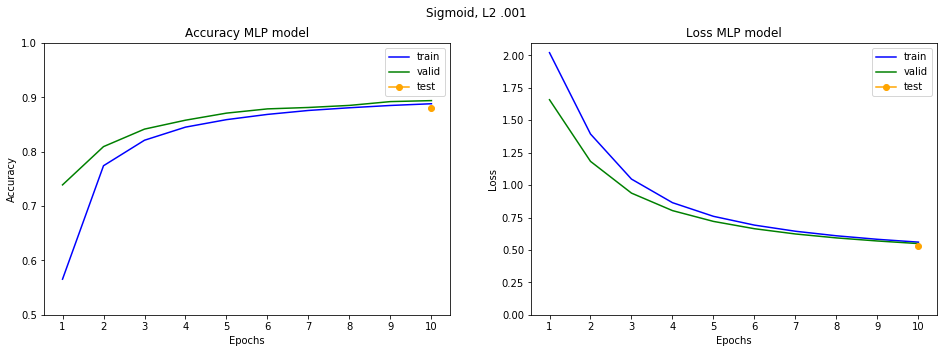

10000/10000 [==============================] - 0s 10us/step


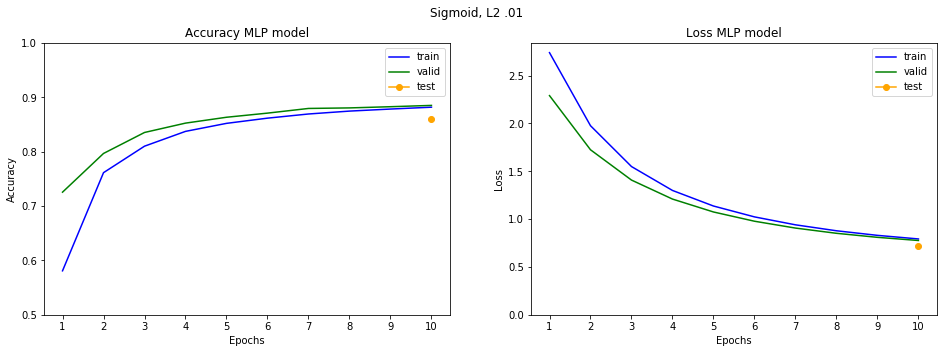

10000/10000 [==============================] - 0s 8us/step


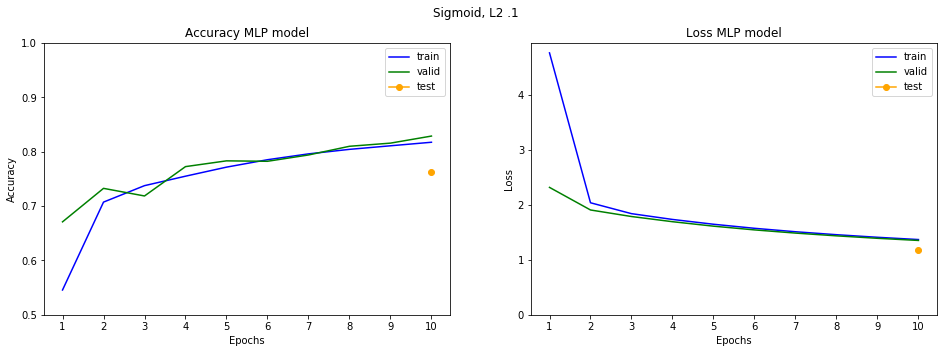

10000/10000 [==============================] - 0s 9us/step


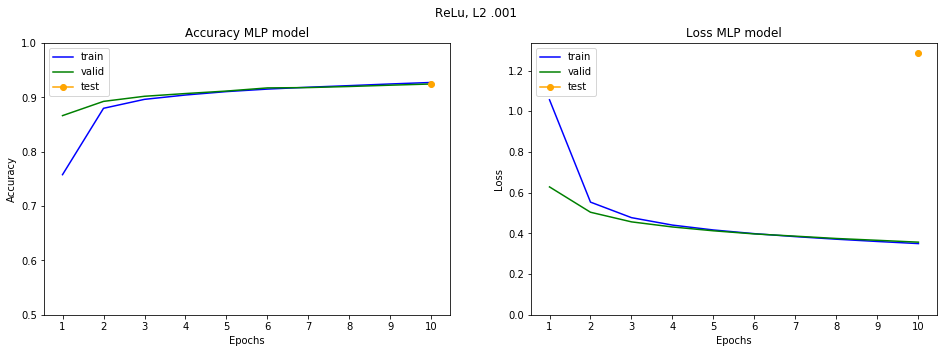

10000/10000 [==============================] - 0s 8us/step


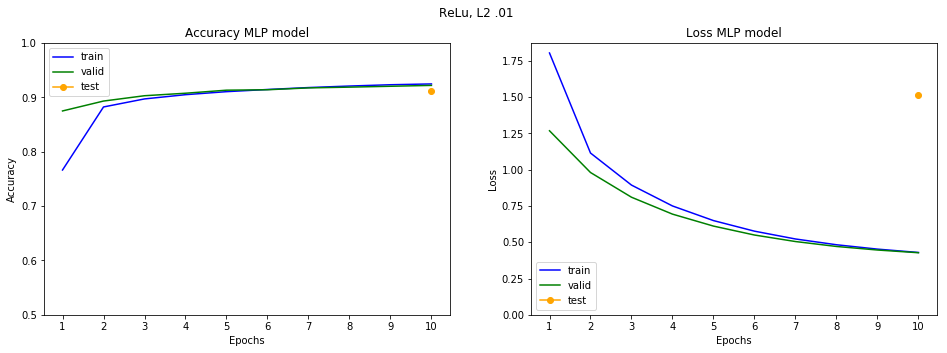

10000/10000 [==============================] - 0s 9us/step


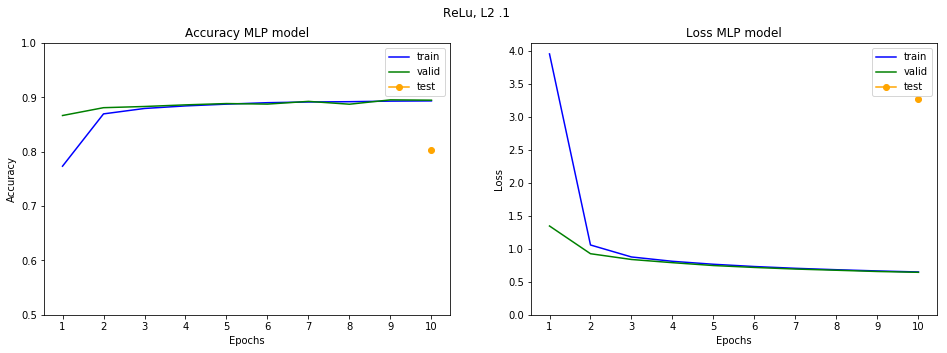

In [30]:
res_plot(history_sig_001, model_sig_001, "Sigmoid, L2 .001")
res_plot(history_sig_01, model_sig_01, "Sigmoid, L2 .01")
res_plot(history_sig_1, model_sig_1, "Sigmoid, L2 .1")
res_plot(history_rel_001, model_rel_001, "ReLu, L2 .001")
res_plot(history_rel_01, model_rel_01, "ReLu, L2 .01")
res_plot(history_rel_1, model_rel_1, "ReLu, L2 .1")

Overall the train and validation set reach similar performance after ca 5 epochs. Both measures show better performance of the validation set over the training set. One reason for the discrepancy could be in how the epoch accuracy and loss are calculated for training and validation set. each epoch trains the network on the entire training set in batches. The accuracy seen in the graph for the training set is average batch performance. This means that the batches in the beginning will have a much lower accuracy and higher loss than later batches in the epoch, which overall results in lower accuracy and loss. The neural network used in this example is quite small and learns relatively quickly, so that we would expect large improvements during the epochs. The validation data on the other hand is only evaluated at the end of each epoch, when the network has trained on the entire training set. This could be an explanation for the overall higher performance of the validation set.  

---

Saving the model to json string and to a file. 

Saving the weights of the latest model to hdf5 file.

In [36]:
model_LR_005, history_LR_005 = simple_NN(x_train, y_train, x_valid, y_valid, LR = 0.005)
model_LR_05, history_LR_05 = simple_NN(x_train, y_train, x_valid, y_valid, LR = 0.05)
model_LR_5, history_LR_5 = simple_NN(x_train, y_train, x_valid, y_valid, LR = 0.5)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 2s 29us/step - loss: 0.6153 - acc: 0.8591 - val_loss: 0.4168 - val_acc: 0.9144
Epoch 2/10
55000/55000 [==============================] - 1s 24us/step - loss: 0.3772 - acc: 0.9207 - val_loss: 0.3561 - val_acc: 0.9264
Epoch 3/10
55000/55000 [==============================] - 1s 24us/step - loss: 0.3268 - acc: 0.9337 - val_loss: 0.3243 - val_acc: 0.9316
Epoch 4/10
55000/55000 [==============================] - 1s 23us/step - loss: 0.2914 - acc: 0.9417 - val_loss: 0.2936 - val_acc: 0.9372
Epoch 5/10
55000/55000 [==============================] - 1s 24us/step - loss: 0.2650 - acc: 0.9474 - val_loss: 0.2726 - val_acc: 0.9394
Epoch 6/10
55000/55000 [==============================] - 1s 24us/step - loss: 0.2445 - acc: 0.9522 - val_loss: 0.2559 - val_acc: 0.9448
Epoch 7/10
55000/55000 [==============================] - 1s 23us/step - loss: 0.2279 - acc: 0.9566 - val_loss: 0.2382 - val_acc:

10000/10000 [==============================] - 0s 12us/step


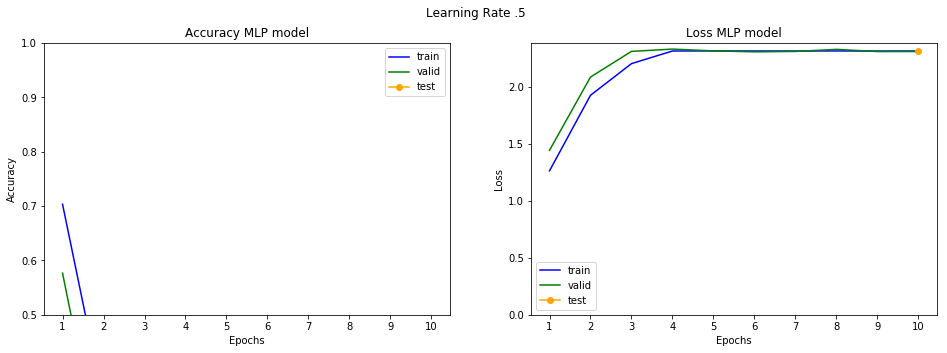

10000/10000 [==============================] - 0s 10us/step


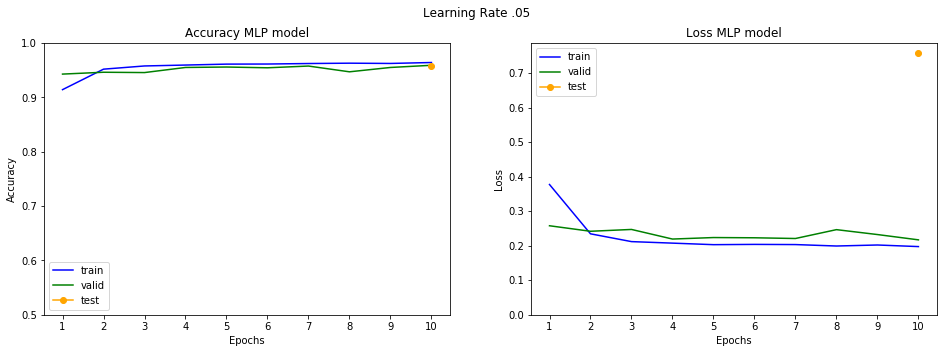

10000/10000 [==============================] - 0s 9us/step


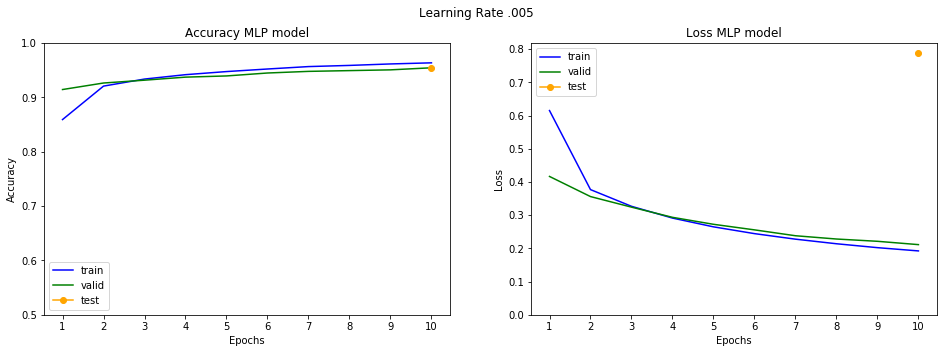

In [37]:
res_plot(history_LR_5, model_LR_5, "Learning Rate .5")
res_plot(history_LR_05, model_LR_05, "Learning Rate .05")
res_plot(history_LR_005, model_LR_005, "Learning Rate .005")

In [20]:
json_string = model.to_json()
with open("model_mlp.json", "w") as json_file:
    json_file.write(json_string)

model.save_weights("weights_mlp.hdf5")

Load model from json and reload the weights. 

In [ ]:
with open("model_mlp.json", "r") as json_file:
    load_json_model = json_file.read()
    
loaded_model = keras.models.model_from_json(load_json_model)
loaded_model.load_weights("weights_mlp.hdf5", by_name=False)

This code snippet will load the model after the first training epoch and restore the weights 

In [ ]:
new_model = keras.models.load_model("checkpoints/model_01.hdf5")
new_model.summary()
new_model.evaluate(x_train, y_train, batch_size = 128)

## Lenet and MNIST

In this section of the notebook 

In [14]:
from keras.layers import Conv2D, MaxPooling2D

Lenet = Sequential([
    Conv2D(input_shape = (1,28, 28), filters = 6, kernel_size = 5, strides = 1, activation = "tanh", name = "Conv1", padding = "same", data_format = "channels_first"),
    MaxPooling2D(pool_size = 2, name = "Pool1", data_format = "channels_first"),
    Conv2D(filters = 16, kernel_size = 5, strides = 1, activation = "tanh", name = "Conv2", data_format = "channels_first"),
    MaxPooling2D(pool_size = 2, name = "Pool2", data_format = "channels_first"),
    Conv2D(filters = 120, kernel_size = 5, strides = 1, activation = "tanh", name = "Conv3",data_format = "channels_first"),
    Flatten(name = "flatten"),
    Dense(84, name = "hidden_2", activation = "tanh"),
    Dense(10, name = "out", activation = "softmax")
])

Lenet.compile(optimizer = "sgd",
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

Lenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 6, 28, 28)         156       
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 6, 14, 14)         0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 16, 10, 10)        2416      
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 16, 5, 5)          0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 120, 1, 1)         48120     
_________________________________________________________________
flatten (Flatten)            (None, 120)               0         
_________________________________________________________________
hidden_2 (Dense)             (None, 84)                10164     
__________

In [15]:
checkpoints = keras.callbacks.ModelCheckpoint("./checkpoints/Lenet_{epoch:02d}.hdf5", 
                                              monitor='val_loss', 
                                              verbose=0, 
                                              save_best_only=False, save_weights_only=False)

Lenet_trained = Lenet.fit(x_train, y_train, 
                    epochs = 10, batch_size = 64, 
                    callbacks = [checkpoints], 
                    validation_data = (x_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 55s 1ms/step - loss: 0.9285 - acc: 0.7717 - val_loss: 0.3712 - val_acc: 0.9006
Epoch 2/10
55000/55000 [==============================] - 55s 1ms/step - loss: 0.2954 - acc: 0.9200 - val_loss: 0.2301 - val_acc: 0.9366
Epoch 3/10
55000/55000 [==============================] - 55s 995us/step - loss: 0.2004 - acc: 0.9439 - val_loss: 0.1657 - val_acc: 0.9556
Epoch 4/10
55000/55000 [==============================] - 53s 966us/step - loss: 0.1518 - acc: 0.9574 - val_loss: 0.1317 - val_acc: 0.9632
Epoch 5/10
55000/55000 [==============================] - 55s 991us/step - loss: 0.1239 - acc: 0.9654 - val_loss: 0.1123 - val_acc: 0.9692
Epoch 6/10
55000/55000 [==============================] - 54s 989us/step - loss: 0.1061 - acc: 0.9699 - val_loss: 0.0988 - val_acc: 0.9720
Epoch 7/10
55000/55000 [==============================] - 54s 987us/step - loss: 0.0932 - acc: 0.9736 - val_loss: 0.0911 

In [17]:
import pandas as pd

Lenet_eval = Lenet.evaluate(x_test, y_test, batch_size = 128)
Lenet_pred = Lenet.predict(x_test, batch_size = 128)

test_actu = np.argmax(y_test, axis = 1, out = None)
test_pred = np.argmax(Lenet_pred, axis = 1, out = None)

confusion = pd.crosstab(test_actu, test_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(confusion)
print("Test-Set:")
print("Accuracy :", Lenet_eval[1], "Loss :", Lenet_eval[0])

10000/10000 [==============================] - 5s 537us/step
Predicted    0    1     2     3    4    5    6     7    8    9    All
Actual                                                               
0          841    0    29     7   12   23    2    55   11    0    980
1            0  793    24   130    2    0    0   169   17    0   1135
2            1    1   900    80    5    2    0    36    7    0   1032
3            0    0     1   982    3   18    0     4    1    1   1010
4            0    0     5    30  789    5    0    64    7   82    982
5            0    0     0   107    0  778    1     1    5    0    892
6           12    1    73    31   27   32  762     3   17    0    958
7            0    0     4    26    5    2    0   962    1   28   1028
8            0    3    15   146    2   18    0    22  766    2    974
9            1    2     1    35  102   39    0    42    8  779   1009
All        855  800  1052  1574  947  917  765  1358  840  892  10000
Test-Set:
Accuracy : 0.8352 L

In [ ]:
tbcallback = keras.callbacks.TensorBoard(log_dir='./logs', 
                            histogram_freq=0, 
                            batch_size=32, 
                            write_graph=True, write_grads=True, write_images=True, 
                            embeddings_freq=0, embeddings_layer_names=None, 
                            embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
callbacks = [tbcallback]

In [53]:
test_pred.shape

(10000, 1, 10)

In [54]:
Lenet.evaluate(x_train, y_train, batch_size = 128)

ValueError: Error when checking target: expected out to have 4 dimensions, but got array with shape (55000, 10)